## Implement of a curvature tensor

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import pandas as pd
import skdim

In [2]:
u_lim = 5
a, b, c = 0.05, 0.05, 0.05
J_length = 6
J_radius = 3

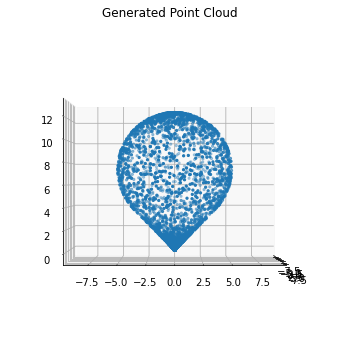

In [3]:
def generate_ballon(a, b, c, u_lim = 5, J_length = 6, J_radius = 3, num_points=5000, shuffle = True):
    num_hyper = int(num_points * 0.4)
    num_sphere = int(num_points * 0.4)
    num_J = int(num_points * 0.2)
    
    #generate hyperboloid upper
    u = np.random.uniform(0, u_lim, num_hyper)
    v = np.random.uniform(0, 2 * np.pi, num_hyper)

    x_h = a*np.cosh(u)*np.cos(v)
    y_h = b*np.cosh(u)*np.sin(v)
    z_h = c*np.sinh(u)

    hyper = np.column_stack((x_h, y_h, z_h))
    
    #generate sphere upper
    theta = np.random.uniform(0, 2 * np.pi, num_sphere)
    phi = np.random.uniform(0, np.pi/2 + np.arctan((b*np.sinh(u_lim))/(c*np.cosh(u_lim))), num_sphere)
    
    radius = np.sqrt(b**2 * np.cosh(u_lim)**2 + (b**4 * np.sinh(u_lim)**2)/c**2)

    x_s = radius * np.sin(phi) * np.cos(theta)
    y_s = radius * np.sin(phi) * np.sin(theta)
    z_s = radius * np.cos(phi) + b**2 * np.sinh(u_lim)/c + c*np.sinh(u_lim)
    z_0 = b**2 * np.sinh(u_lim)/c + c*np.sinh(u_lim)
    
    sphere = np.column_stack((x_s, y_s, z_s))
    center = np.column_stack((0, 0, z_0))
    
    #generate J shape
    total = J_length + np.pi * J_radius
    ratio_1 = J_length/total
    num_1 = int(num_J * ratio_1)
    t = np.linspace(0, - J_length, num_1)
    x1, y1 = np.zeros(num_1), np.zeros(num_1)
    z1 = t
    X1 = np.zeros((num_1,3))
    X1[:, 0] = x1
    X1[:, 1] = y1
    X1[:, 2] = z1
    
    num_2 = num_J - num_1
    theta = np.linspace(np.pi, 2*np.pi, num_2)
    x2 = np.zeros(num_2)
    y2 = -J_radius + J_radius * np.cos(theta)
    z2 = -J_length + J_radius * np.sin(theta)
    X2 = np.zeros((num_2,3))
    X2[:, 0] = x2
    X2[:, 1] = y2
    X2[:, 2] = z2
    
    J = np.concatenate((X1, X2), axis= 0)
    
    Y = np.concatenate((hyper, sphere, J), axis= 0)
    if shuffle:
        np.random.shuffle(Y)

    return Y, center


np.random.seed(40)
# Generate a sphere point cloud with 1000 points and radius 1

cloud1, center1 = generate_ballon(a, b, c, u_lim = u_lim, 
                                  J_length = J_length, J_radius = J_radius, num_points=5000, shuffle = False)
cloud, center = generate_ballon(a, b, c,u_lim = u_lim, shuffle = False)
cloud = cloud[:4000]
np.random.shuffle(cloud)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=5)
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()

In [4]:
x = cloud[0].reshape(1, -1)
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(cloud)
dist_i, indx_i = nbrs.kneighbors(x)

In [5]:
indx_i[0][0]

0

In [6]:
def sub_vectors_between(set_vectors, a, b):
    # this function selects a set of vectors whose entries are between a and b
    
    filtered_vector = [[x for x in v if a < x < b] for v in set_vectors ]
    return filtered_vector        

def list_vector_indices_upto(list_indices, list_of_nums):
    result_list = [[list_indices[i][j] for j in range(list_of_nums[i] + 1)] for i in range(len(list_indices))]
    return result_list

def list_vector_of_index(set_vectors, list_indices):
    
    list_result_vectors = [np.array([set_vectors[i] for i in list_indices[j]]) for j in range(len(list_indices))]
    return list_result_vectors 


In [7]:
def compute_curvature_old(point_cloud, query_point, epsilon_PCA = 0.1, dim = 2, tau_ratio = 1.5):
    
    ep_neighbor, tau_neighbor, tau_epsilon_neighbor, O = find_basis(point_cloud, query_point, epsilon_PCA = epsilon_PCA,
                                                                    dim = dim, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), dim, dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []

    O_init = O[0].T  # this is the basis at point o, it is 2 x 3
    v_init =  O_init[0] #choose the initial vector
    for i in np.arange(1, len(tau_neighbor)):
        for j in np.arange(i + 1, len(tau_neighbor)):
            O_fin = O_init.T @ transport_maps[0, i] @ transport_maps[i, j] @ transport_maps[j, 0]
            v_fin = O_fin.T[0]
            
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            if cosin>1: cosin = 1
            if cosin<-1: cosin = -1
            angle = np.arccos(cosin)
            area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
            #tensor = angle / area
            tensor = (2 * np.pi - angle) / area 
            
            tensor_av.append(tensor)
            
            #tensor = angle / area                                  

    
    
    tensor_av = sum(tensor_av)/len(tensor_av)
         
    return transport_maps, tensor_av
 

In [8]:
def find_basis_at_point(point_cloud, x, global_center, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 1.5):
    #point_cloud: the manifold 
    #x: np.array of shape 1 by p, the point where the curvature is evaluated at, e.g., [[1, 2, 3]]
    #epsilon: the radius of local PCA
    #dim: the dimension of the manifold
    #tau_ratio: the ratio is tau radius (where we evaluate the curvature)/ epsilon_sqrt
    epsilon_sqrt = np.sqrt(epsilon_PCA)
    tau = tau_ratio * epsilon_sqrt

    # Number of neighbors to find, we take 5% of the total population
    k = int(0.05 * point_cloud.shape[0])
    
    # Create a NearestNeighbors model
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(point_cloud)

    # Find k nearest neighbors
    dist_i, indx_i = nbrs.kneighbors(x)
    x_idx = indx_i[0][0]
    # Find epsilon neighborhood
    dist_epsilon = sub_vectors_between(dist_i, 0, epsilon_sqrt)
    len_dist_epsilon = [len(v) for v in dist_epsilon]
    epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_epsilon))[0]
    # Find tau neighborhood
    dist_tau = sub_vectors_between(dist_i, 0, tau)
    len_dist_tau = [len(v) for v in dist_tau]
    tau_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indx_i, len_dist_tau))[0]
    num = len(tau_neighborhood)
    
    distances, indices = nbrs.kneighbors(tau_neighborhood)
    
    distances_epsilon = sub_vectors_between(distances, 0, epsilon_sqrt) # this is the list of distances in the epsilon
    list_len_dist_epsilon = [len(v) for v in distances_epsilon] #this gives the list of lengths in the distance_epsilon 
    
    tau_epsilon_neighborhood = list_vector_of_index(point_cloud, list_vector_indices_upto(indices, list_len_dist_epsilon))
    list_X_i = [tau_epsilon_neighborhood[i][1:] - tau_neighborhood[i] for i in range(num)]
    
    
    #list_D_i = [np.diag(np.sqrt(np.exp(- np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for i in range(num)]
    list_D_i = [np.diag(np.sqrt(np.exp( - 8 * np.array(distances_epsilon[i]) ** 2 / epsilon_PCA))) for 
                i in range(num)]
    list_B_i = [list_X_i[j].T @ list_D_i[j] for j in range(num)]
    
    lpca = skdim.id.lPCA().fit_pw(point_cloud, n_neighbors = 10, n_jobs = 1)
    dim = lpca.dimension_pw_[x_idx]
    
    O = []
    for q in range(num):
        U, S, VT = np.linalg.svd(list_B_i[q].T)
        O_i = VT[:extrin_dim, :]
        #if np.dot(O_i[dim], (x - global_center[0])[0]) < 0:
         #   O_i[dim] = - O_i[dim]
            
        O.append(O_i)
        
    return x_idx, dim, tau_neighborhood, O



In [9]:
idx =2000

In [10]:
query_point = cloud[idx].reshape(1, -1)

x_idx, dim, tau_neighbor, O = find_basis_at_point(cloud, query_point, center, 
                                                  epsilon_PCA = 0.8, tau_ratio = 1)

In [11]:
U, S, VT = np.linalg.svd(O[4].T @ O[6], full_matrices = False)
U @ VT

array([[-0.83150312,  0.02129069,  0.55511195],
       [-0.16989136,  0.9416426 , -0.29059618],
       [-0.52890405, -0.33594035, -0.77936165]])

In [12]:
O[0][2]

array([ 0.02727961, -0.99953961,  0.01328098])

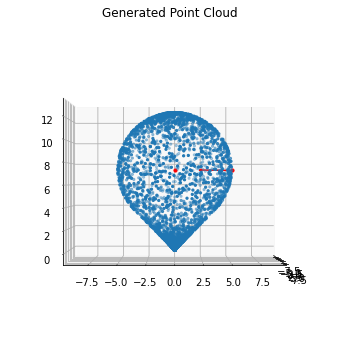

In [13]:
def plot_vector(ax, a, v, color='red', label=None):
    ax.quiver(a[0], a[1], a[2], v[0], v[1], v[2], color=color, label=label, arrow_length_ratio=0.1)

# Visualize the point cloud
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], s=5)
ax.scatter(cloud[idx, 0], cloud[idx, 1], cloud[idx, 2], s=10, c = 'r')
ax.scatter(center[:, 0], center[:, 1], center[:, 2], s=10, c = 'r')
plot_vector(ax, cloud[idx], 3 * O[0][2])
ax.set_title("Generated Point Cloud")
ax.view_init(0, 0)
plt.axis('equal')
plt.show()


In [14]:
U, S, VT = np.linalg.svd(O[2].T @ O[3], full_matrices = False)
U @ VT @ O[0][0]

array([-0.7511284 , -0.1673111 ,  0.63860248])

In [15]:
def compute_curvature_at_point(point_cloud, query_point, extrin_dim = 3, epsilon_PCA = 0.1, tau_ratio = 1.5):
    
    x_idx, dim, tau_neighbor, O = find_basis_at_point(point_cloud, query_point, 
                                                      epsilon_PCA = epsilon_PCA, tau_ratio = tau_ratio)
    
    transport_maps = np.zeros((len(tau_neighbor), len(tau_neighbor), extrin_dim, extrin_dim))
    for i in range(len(tau_neighbor)):
        for j in range(len(tau_neighbor)):
            U, S, VT = np.linalg.svd(O[i].T @ O[j], full_matrices = False)
            O_ij = U @ VT
            transport_maps[i,j] = O_ij
            
    tensor_av = []

    O_init = O[0]  # this is the basis at point o, it is 2 x 3
    v_init = O_init[0] #choose the initial vector
    if dim == 1:
        for i in np.arange(1, len(tau_neighbor)):
            O_fin =  transport_maps[0, i] @ O_init[0]
            v_fin = O_fin
            cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
            if cosin>1: cosin = 1
            if cosin<-1: cosin = -1
            angle = np.arccos(cosin)
            area = np.linalg.norm(tau_neighbor[i] - tau_neighbor[0])
            tensor = angle / area
            tensor_av.append(tensor)
    else: 
        for i in np.arange(1, len(tau_neighbor)):
            for j in np.arange(i + 1, len(tau_neighbor)):
                O_fin = transport_maps[0, i] @ transport_maps[i, j] @ transport_maps[j, 0] @ O_init.T
                v_fin = O_fin.T[0]
            
                cosin = (v_init @ v_fin.T) / (np.linalg.norm(v_init) * np.linalg.norm(v_fin))
                if cosin>1: cosin = 1
                if cosin<-1: cosin = -1
                angle = np.arccos(cosin)
                area = np.linalg.norm(np.cross(tau_neighbor[i] - tau_neighbor[0], tau_neighbor[j] - tau_neighbor[0])) / 2
            
                #tensor = angle / area
                tensor = (2 * np.pi - angle) / area 
            
                tensor_av.append(tensor)                                 
    
    tensor_av = sum(tensor_av)/len(tensor_av)
         
    return transport_maps, tensor_av
 

In [16]:
def compute_sectional_curvature(point_cloud, query_point, global_center, extrin_dim = 3, 
                                epsilon_PCA = 0.1, tau_ratio = 0.5, max_min_num = 10):
    
    x_idx, dim, tau_neighbor, O = find_basis_at_point(point_cloud, query_point, global_center, extrin_dim = extrin_dim, 
                                                      epsilon_PCA = epsilon_PCA, tau_ratio = tau_ratio)
            
    tensor_all = []
    for i in np.arange(1, len(tau_neighbor)):
        tensor = 2 * (sum(O[0][dim] *  (tau_neighbor[i] - tau_neighbor[0])))/np.linalg.norm(tau_neighbor[i] - tau_neighbor[0])**2
        tensor_all.append(tensor)
        
    
    #tensor_av = sum(tensor_av)/len(tensor_av)
    #max_cur = sorted(tensor_all, reverse=True)[:max_min_num]
    max_cur = sum(sorted(tensor_all, reverse=True)[:max_min_num])/max_min_num
    #min_cur = sorted(tensor_all)[:max_min_num]
    
    min_cur = sum(sorted(tensor_all)[:max_min_num])/max_min_num
    
    return max_cur * min_cur
 

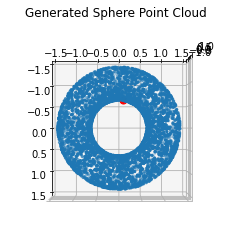

In [17]:
def generate_torus_point_cloud(num_points = 5000, R = 3, r = 1):
    # Generate random angles for theta and phi
    theta = np.random.uniform(0, 2*np.pi, num_points)
    phi = np.random.uniform(0, 2*np.pi, num_points)

    # Compute the torus points
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    x_c = R * np.cos(theta)
    y_c = R * np.sin(theta)
    z_c = np.zeros(x.shape)
    
    

    return np.column_stack((x, y, z)), np.column_stack((x_c, y_c, z_c))

# Create torus parameters
R = 1 # Major radius
r = 0.375  # Minor radius
num_samples = 5000



# Generate a sphere point cloud with 1000 points and radius 1
torus_cloud, torus_centers = generate_torus_point_cloud(num_points = num_samples, R = R, r = r)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(torus_cloud[:, 0], torus_cloud[:, 1], torus_cloud[:, 2], s=5)
ax.scatter(torus_cloud[0, 0], torus_cloud[0, 1], torus_cloud[0, 2], s=50, c = 'r')
#ax.scatter(torus_centers[:, 0], torus_centers[:, 1], torus_centers[:, 2], s=5, c = 'r')
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(90, 0)
plt.show()

In [18]:
compute_sectional_curvature(torus_cloud, torus_cloud[0].reshape(1, -1), 
                            torus_centers[0].reshape(1, -1), epsilon_PCA =0.1, tau_ratio = 4)

-4.915613721496366

In [29]:
num_eval = int(len(torus_cloud)/5)
curvature = []
for i in tqdm(range(num_eval)):
    b = compute_sectional_curvature(torus_cloud, torus_cloud[i].reshape(1, -1), 
                                       torus_centers[i].reshape(1, -1), epsilon_PCA =0.1, tau_ratio = 2)
    curvature.append(b)

100%|██████████| 1000/1000 [17:43<00:00,  1.06s/it]


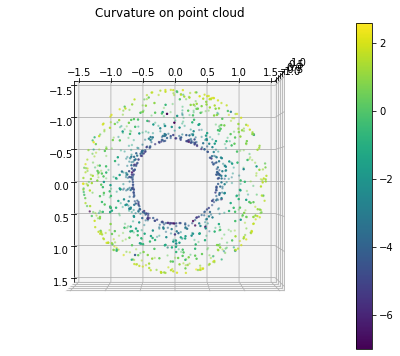

In [32]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(torus_cloud[:num_eval, 0], torus_cloud[:num_eval, 1], torus_cloud[:num_eval, 2], s=2, c = dd)
ax.set_title("Curvature on point cloud")
ax.view_init(90, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [31]:
dd = np.clip(v, a_max=None, a_min=-7)

In [36]:
def generate_ellipsoid_cloud(a, b, c, num_points = 5000):
    """Generate a random point on an ellipsoid defined by a,b,c"""
    
    theta = np.random.uniform(0, 2*np.pi, num_points)
    v = np.random.rand(num_points)
    phi = np.arccos(2.0 * v - 1.0)
    sinTheta = np.sin(theta);
    cosTheta = np.cos(theta);
    sinPhi = np.sin(phi);
    cosPhi = np.cos(phi);
    rx = a * sinPhi * cosTheta;
    ry = b * sinPhi * sinTheta;
    rz = c * cosPhi;
    return np.column_stack((rx, ry, rz))

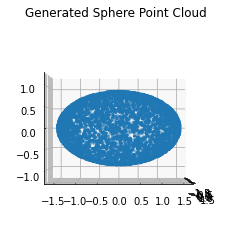

In [43]:
ellipsoid = generate_ellipsoid_cloud(0.9, 1.5, 0.9)

# Visualize the point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ellipsoid[:, 0], ellipsoid[:, 1], ellipsoid[:, 2], s=5)
ax.set_aspect('equal')
ax.set_title("Generated Sphere Point Cloud")
ax.view_init(0, 0)
plt.show()

In [46]:
num_eval = int(len(ellipsoid)/5)
center = np.array([[0, 0, 0]])
curvature = []
for i in tqdm(range(num_eval)):
    a, b = compute_sectional_curvature(ellipsoid, ellipsoid[i].reshape(1, -1), center, epsilon_PCA =0.1, tau_ratio = 1.5)
    curvature.append(b)

100%|██████████| 1000/1000 [22:56<00:00,  1.38s/it]


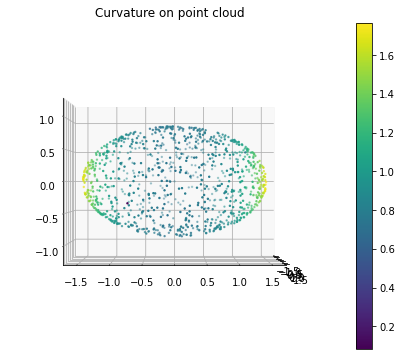

In [47]:
v = np.array(curvature).T
# Visualize the point cloud
cc = -v
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(ellipsoid[:num_eval, 0], ellipsoid[:num_eval, 1], ellipsoid[:num_eval, 2], s=2, c = cc)
ax.set_title("Curvature on point cloud")
ax.view_init(0, 0)
plt.colorbar(scatter)
ax.set_aspect('equal')
plt.show()

In [409]:
dd = np.clip(v, a_max=5, a_min=None)

In [364]:
np.argsort(v)[:20]

array([388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 187,
       172, 186, 171, 173,  12,   8,  13])

In [365]:
v[13]

9.755429511033384

In [259]:
def angle_between(u, v, n=None):
    
    if n is None:
        return np.arctan2(np.linalg.norm(np.cross(u,v)), np.dot(u,v))
    else:
        return np.arctan2(np.dot(n,np.cross(u,v)), np.dot(u,v))

In [265]:
u = O[0].T[0]
v = O[1].T[0]

In [277]:
angle_between(v, u, 1)

array([ 5.14172284e-03,  5.73146157e-17, -9.50858157e-17])

In [276]:
angle_between(u, v, 1)

array([-5.14172284e-03, -5.73146157e-17,  9.50858157e-17])